In [44]:
from os import path
import os
import glob
import warnings

import astropy.coordinates as coord
from astropy.table import Table, hstack, join
import astropy.units as u
from astropy.io import ascii
from astropy.io import fits
import reproject

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from scipy.spatial import cKDTree

from pyia import GaiaData
import gala.coordinates as gc
from dustmaps.sfd import SFDQuery
from astroquery.gaia import Gaia
import healpy as hp
import pandas as pd

from sfd import reddening

login_file = path.expanduser('~/.gaia/archive.login')
if path.exists(login_file):
    with open(login_file) as f:
        username = f.readline()
        password = f.readline()
    print('Logging in with user: {0}'.format(username))
    Gaia.login(user=username, password=password)

Logging in with user: apricewh



### Load known things:

In [51]:
glob = Table.read('/Users/adrian/data/Misc/Harris-globclust.fits')
gals = ascii.read('/Users/adrian/data/Misc/NearbyGalaxies.dat')

glob_c = coord.SkyCoord(ra=glob['ra'], dec=glob['dec'], unit=(u.hourangle, u.degree))
gals_c = coord.SkyCoord(ra=gals['RA'], dec=gals['Dec'], unit=(u.hourangle, u.degree))
known_c = coord.concatenate((glob_c, gals_c))
known_names = np.concatenate((np.array(glob['name']), np.array(gals['name'])))

In [21]:
def coords_to_map(c, nside=2048):
    c = c.represent_as('physicsspherical')
    theta = c.theta.radian
    phi = c.phi.radian
    
    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta, phi)

    idx, counts = np.unique(indices, return_counts=True)

    # fill the fullsky map
    hpx_map = np.zeros(hp.nside2npix(nside), dtype=int)
    hpx_map[idx] = counts

    return hpx_map

```
SELECT source_id, 
ra, dec, parallax, pmra, pmdec, radial_velocity,
ra_error, dec_error, parallax_error, pmra_error, pmdec_error, radial_velocity_error,
ra_dec_corr, ra_parallax_corr, ra_pmra_corr, ra_pmdec_corr,
dec_parallax_corr, dec_pmra_corr, dec_pmdec_corr, parallax_pmra_corr, parallax_pmdec_corr, pmra_pmdec_corr,
phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag
FROM gaiadr2.gaia_source 
WHERE parallax < 1 AND 
(bp_rp > -0.5) AND (bp_rp < 0) AND 
ABS(b) > 20
```

In [18]:
lmc_c = coord.SkyCoord(ra=81*u.deg, dec=-70*u.deg)
smc_c = coord.SkyCoord(ra=13*u.deg, dec=-73*u.deg)

In [36]:
g = GaiaData('../data/blue-distant-b20-result.fits')
c = g.get_skycoord(distance=False)

mask = ((g.phot_g_mean_mag < 19.*u.mag) & 
        (c.separation(lmc_c) > 15*u.deg) & 
        (c.separation(smc_c) > 8*u.deg))
g = g[mask]
c = g.get_skycoord(distance=False)
len(g)

17941

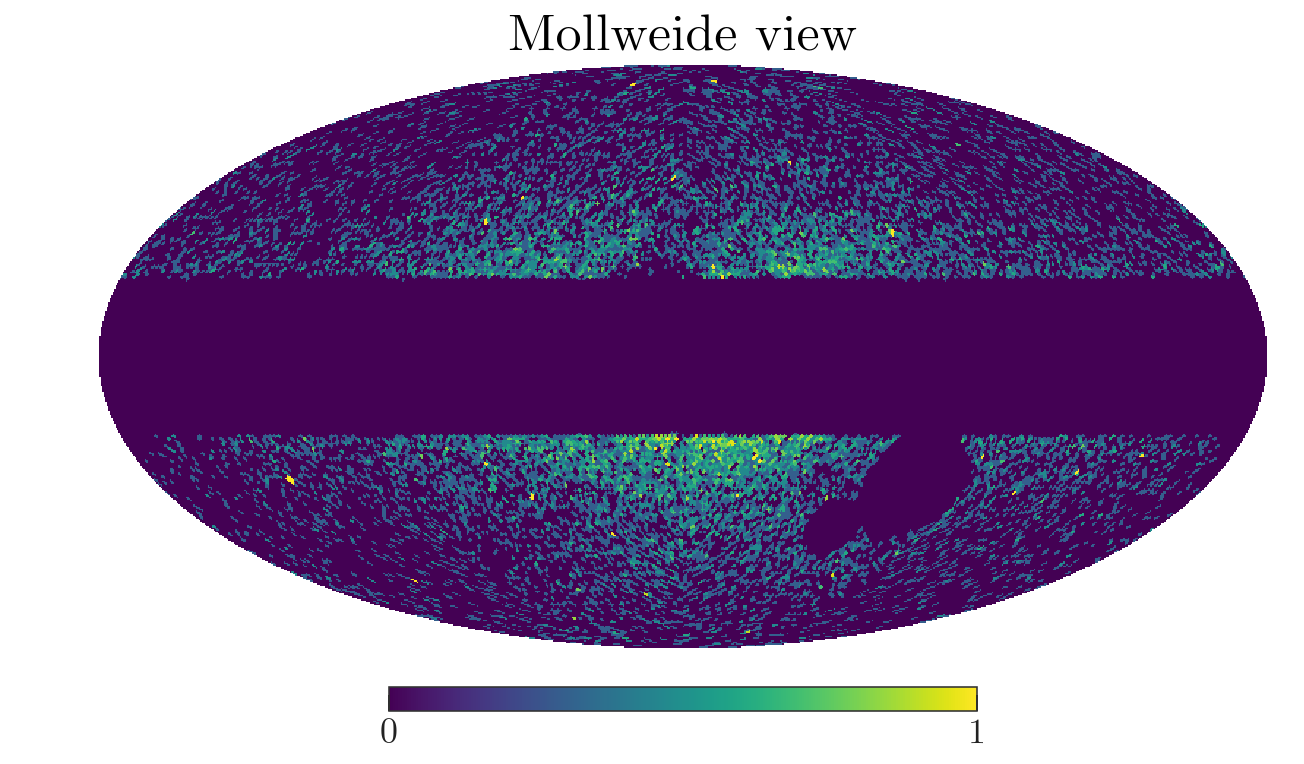

In [37]:
_map = coords_to_map(c.galactic, nside=64)
_ = hp.mollview(np.log10(1 + _map), min=0, max=1.)

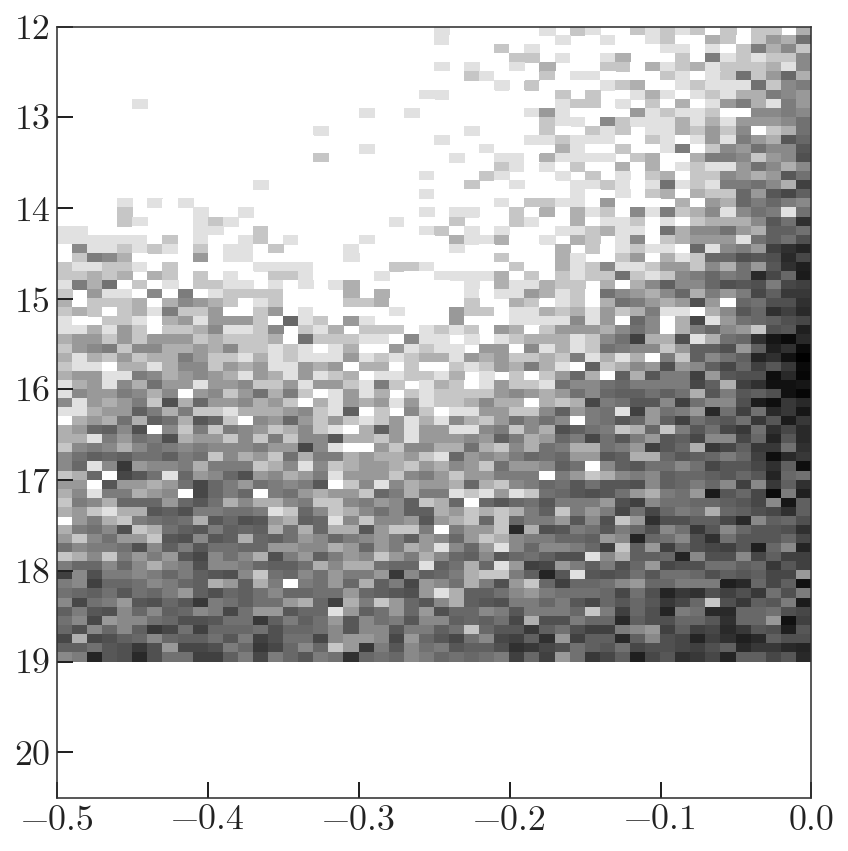

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

bprp = g.phot_bp_mean_mag - g.phot_rp_mean_mag
G = g.phot_g_mean_mag
H, xe, ye = np.histogram2d(bprp, G, 
                           bins=(np.arange(-0.5, 0+1e-3, 0.01),
                                 np.arange(12, 20.5+1e-3, 0.1)))
ax.pcolormesh(xe, ye, H.T, norm=mpl.colors.LogNorm(),
              cmap='Greys')

ax.set_ylim(20.5, 12)

fig.tight_layout()

In [41]:
def get_sky_pair_idx(lim=10*u.arcmin):
    idx1, idx2, sep, _ = coord.search_around_sky(c, c, seplimit=lim)

    not_self_mask = idx1 != idx2
    idx1 = idx1[not_self_mask]
    idx2 = idx2[not_self_mask]
    
    return set([(x, y) if x < y else (y, x) for x,y in zip(idx1, idx2) ])

def get_pm_pair_idx(lim=0.2*u.mas/u.yr):
    uu = u.mas/u.yr
    tree = cKDTree(np.vstack((c.pm_ra_cosdec.to(uu).value, 
                              c.pm_dec.to(uu).value)).T)
    set_idx = tree.query_pairs(lim.to(uu).value)
    idx1 = np.array(list(set_idx))[:, 0]
    idx2 = np.array(list(set_idx))[:, 1]
    
    return set([(x, y) if x < y else (y, x) for x,y in zip(idx1, idx2) ])

In [47]:
idx_sky = get_sky_pair_idx(lim=30*u.arcmin)
idx_pm = get_pm_pair_idx(lim=0.5*u.mas/u.yr)

idx_sky_pm = idx_sky.intersection(idx_pm)
idx_sky_pm_arr = np.array(list(idx_sky_pm))

Text(0.5,0,'group size')

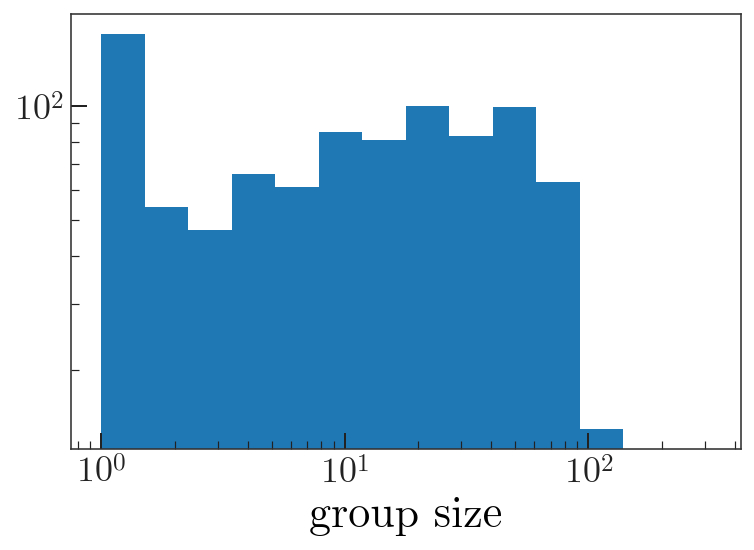

In [48]:
df = pd.DataFrame({'idx1': idx_sky_pm_arr[:, 0],
                   'idx2': idx_sky_pm_arr[:, 1]})
group_size = df.groupby('idx1').size()

plt.hist(group_size, bins=np.logspace(0, 2.5, 15));
plt.xscale('log')
plt.yscale('log')
plt.xlabel('group size')

In [57]:
group_size_lim = 8
n_groups = len(df.groupby('idx1').filter(lambda x: len(x) >= group_size_lim).groupby('idx1'))
print('{0} groups with >= {1} members'.format(n_groups, group_size_lim))

525 groups with >= 8 members


In [58]:
mean_ra = []
mean_dec = []
mean_pmra = []
mean_pmdec = []
for name, grp in df.groupby('idx1').filter(lambda x: len(x) >= group_size_lim).groupby('idx1'):
    mean_ra.append(np.mean(c[grp.idx2].ra.degree))
    mean_dec.append(np.mean(c[grp.idx2].dec.degree))
    mean_pmra.append(np.mean(c[grp.idx2].pm_ra_cosdec))
    mean_pmdec.append(np.mean(c[grp.idx2].pm_dec))
    
mean_ra = np.array(mean_ra)
mean_dec = np.array(mean_dec)
mean_pmra = u.Quantity(mean_pmra)
mean_pmdec = u.Quantity(mean_pmdec)
mean_c = coord.SkyCoord(ra=mean_ra*u.deg, dec=mean_dec*u.deg,
                        pm_ra_cosdec=mean_pmra,
                        pm_dec=mean_pmdec)

In [59]:
mean_idx, mean_sep, _ = mean_c.match_to_catalog_sky(known_c)

Text(0,0.5,'$B_{\\rm MS}$ [deg]')

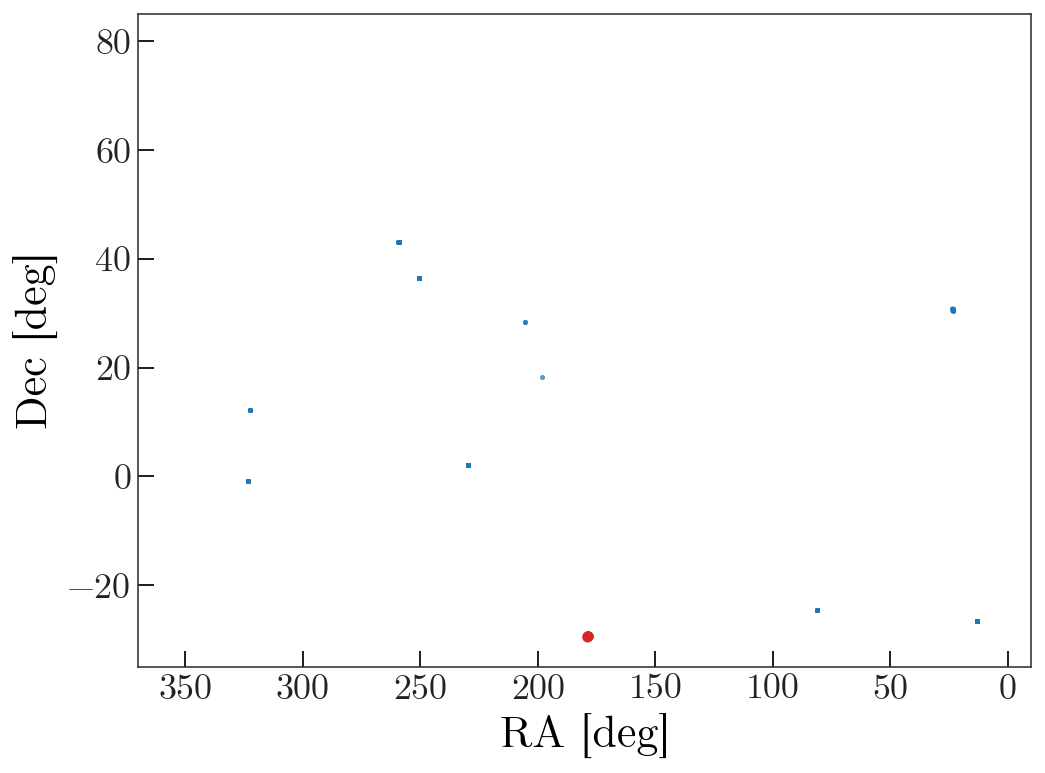

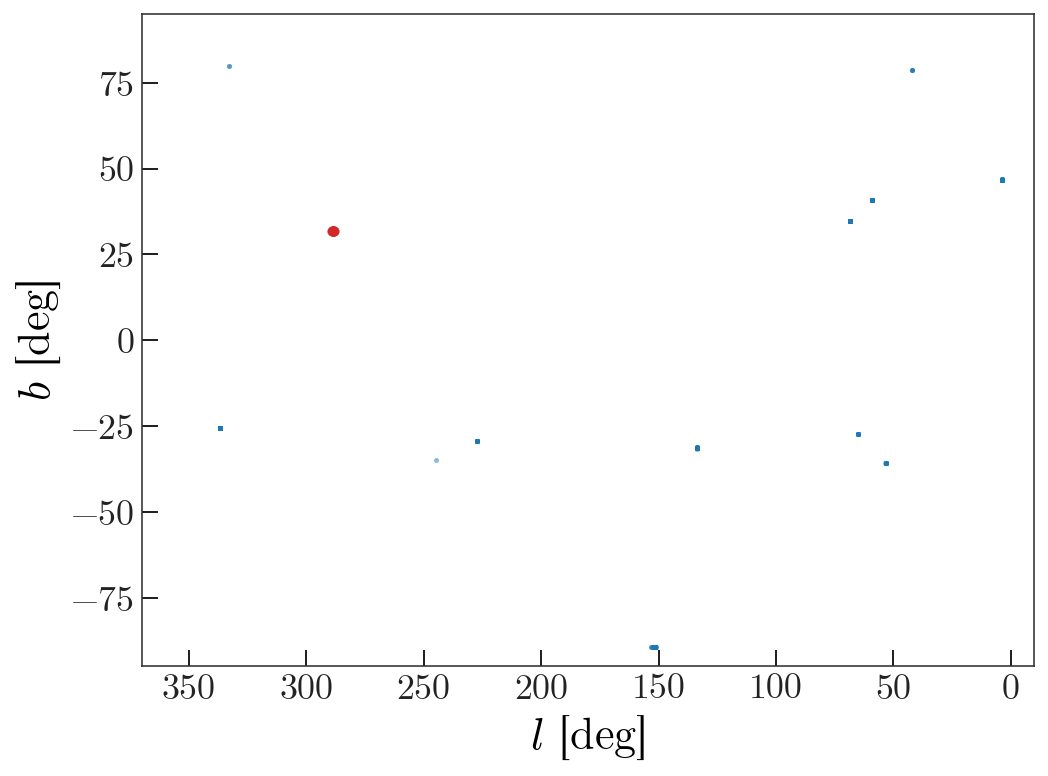

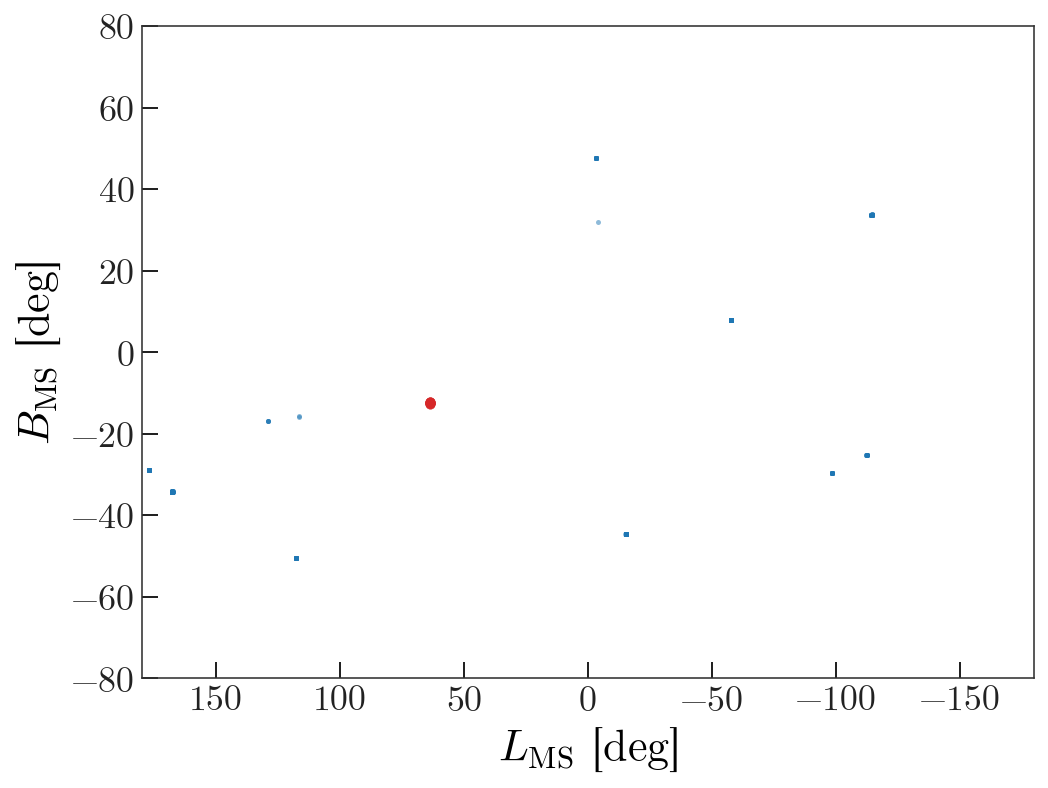

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(mean_ra[mean_sep < 1*u.deg], mean_dec[mean_sep < 1*u.deg], 
        marker='.', ls='none', alpha=0.5, color='tab:blue')
ax.plot(mean_ra[mean_sep > 1*u.deg], mean_dec[mean_sep > 1*u.deg], 
        marker='o', ls='none', alpha=0.5, color='tab:red')

ax.set_xlim(370, -10)
ax.set_ylim(-35, 85)
ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')

# ----

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(mean_c.galactic.l[mean_sep < 1*u.deg], mean_c.galactic.b[mean_sep < 1*u.deg], 
        marker='.', ls='none', alpha=0.5, color='tab:blue')
ax.plot(mean_c.galactic.l[mean_sep > 1*u.deg], mean_c.galactic.b[mean_sep > 1*u.deg], 
        marker='o', ls='none', alpha=0.5, color='tab:red')

ax.set_xlim(370, -10)
ax.set_ylim(-95, 95)
ax.set_xlabel('$l$ [deg]')
ax.set_ylabel('$b$ [deg]')

# ----

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

_c = mean_c.transform_to(gc.MagellanicStream)
ax.plot(_c.L.wrap_at(180*u.deg)[mean_sep < 1*u.deg], _c.B[mean_sep < 1*u.deg], 
        marker='.', ls='none', alpha=0.5, color='tab:blue')
ax.plot(_c.L[mean_sep > 1*u.deg], _c.B[mean_sep > 1*u.deg], 
        marker='o', ls='none', alpha=0.5, color='tab:red')

ax.set_xlim(180, -180)
ax.set_ylim(-80, 80)
ax.set_xlabel(r'$L_{\rm MS}$ [deg]')
ax.set_ylabel(r'$B_{\rm MS}$ [deg]')

Text(0,0.5,'$B_{\\rm MS}$ [deg]')

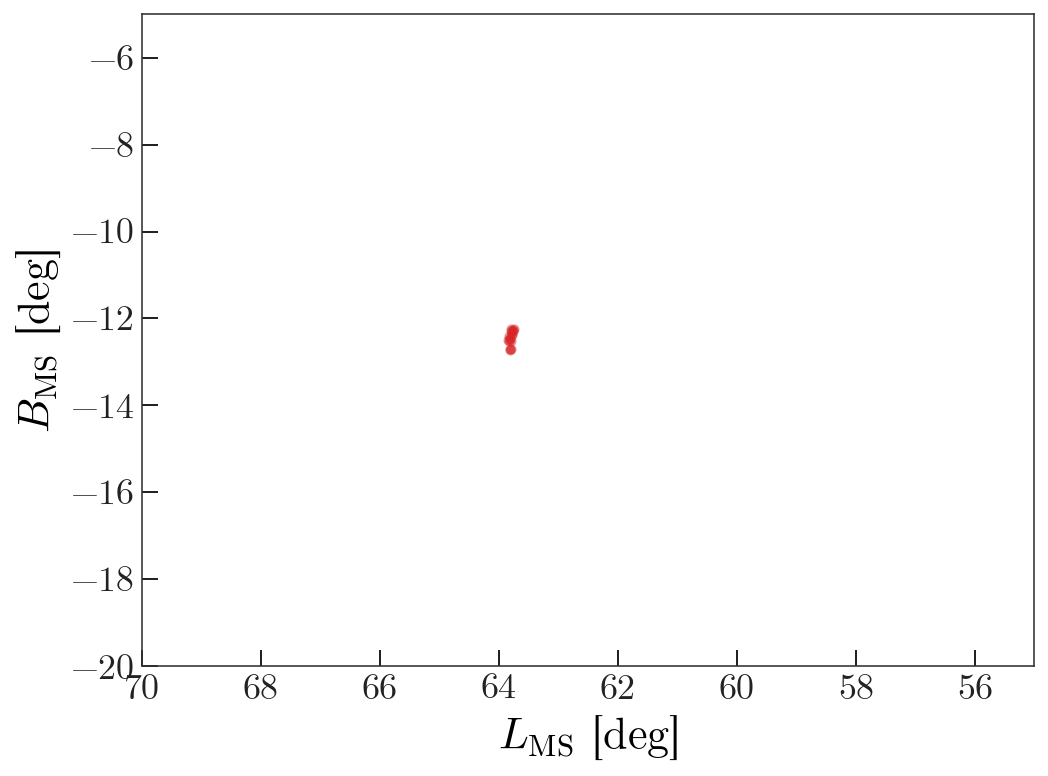

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

_c = mean_c.transform_to(gc.MagellanicStream)
ax.plot(_c.L.wrap_at(180*u.deg)[mean_sep < 1*u.deg], _c.B[mean_sep < 1*u.deg], 
        marker='.', ls='none', alpha=0.5, color='tab:blue')
ax.plot(_c.L[mean_sep > 1*u.deg], _c.B[mean_sep > 1*u.deg], 
        marker='o', ls='none', alpha=0.5, color='tab:red')

ax.set_xlim(70, 55)
ax.set_ylim(-20, -5)
ax.set_xlabel(r'$L_{\rm MS}$ [deg]')
ax.set_ylabel(r'$B_{\rm MS}$ [deg]')